In [56]:

from pathlib import Path

import numpy as np
import pandas as pd
from pymodulon.core import IcaData
from pymodulon.enrichment import compute_enrichment, FDR, compute_trn_enrichment
from pymodulon.util import explained_variance
from pymodulon.io import load_json_model, save_to_json
import seaborn as sns
import matplotlib.pyplot as plt
from pymodulon.util import explained_variance

In [18]:

def get_var_size_table(ica_data):
    var_size_n = []
    for k in ica_data.imodulon_names:
        var = explained_variance(ica_data,imodulons=k)
        size = ica_data.view_imodulon(k).shape[0]
        var_size_n.append((k, var, size))

    table = pd.DataFrame(var_size_n, columns=['m', 'explained_var', 'n'])
    return table


ann = pd.read_csv("Selongatus_PCC7942_ref_tfs.csv", index_col=0)

## Load Metadata from each project
metadata = pd.read_csv('Metadata_Perturbation_Passing_QC.csv')
metadata.rename(columns={"Project_tag":"project", "Condition":"condition"}, inplace=True)

TFs = ann[['ENTRAF_TF', 'DeepTFactor_TF', 'P2TF_TF']]

filtered_df = TFs[TFs.any(axis=1)]
all_tfs = filtered_df.index.values

reg_dict = {'P2TF': set(filtered_df[filtered_df['P2TF_TF'] == True].index),
            'DeepTF': set(filtered_df[filtered_df['DeepTFactor_TF'] == True].index),
            'ENTRAF': set(filtered_df[filtered_df['ENTRAF_TF'] == True].index)}

#Load known regulatory interactions in S. elongatus
regs = pd.read_csv("TRN_complete.csv", index_col=0)
regf = regs.rename(columns={'Regulator_Name':'regulator', 'targetGene':'gene_id'})
regf.drop(['regulatoryGene'], axis=1, inplace=True)
upd_regs = [
    {'regulator':'RpaA', 'target_name':np.nan, 'gene_id':'SYNPCC7942_RS04415'}, # update operon
    {'regulator':'RpaA', 'target_name':np.nan, 'gene_id':'SYNPCC7942_RS04420'}, # update operon 
    {'regulator':'RpaA', 'target_name':np.nan, 'gene_id':'SYNPCC7942_RS04425'}, # update operon 
    {'regulator':'RpaA', 'target_name':np.nan, 'gene_id':'SYNPCC7942_RS04430'}, # update operon 
    {'regulator':'RpaA', 'target_name':np.nan, 'gene_id':'SYNPCC7942_RS06230'}, # update operon 
    {'regulator':'RpaB', 'target_name':np.nan, 'gene_id':'SYNPCC7942_RS04415'}, # update operon 
    {'regulator':'RpaB', 'target_name':np.nan, 'gene_id':'SYNPCC7942_RS04420'}, # update operon 
    {'regulator':'RpaB', 'target_name':np.nan, 'gene_id':'SYNPCC7942_RS04425'}, # update operon 
    {'regulator':'RpaB', 'target_name':np.nan, 'gene_id':'SYNPCC7942_RS04430'}, # update operon 
    {'regulator':'SigF2', 'target_name':np.nan, 'gene_id':'SYNPCC7942_RS12975'}, # update operon 
    {'regulator':'SigF2', 'target_name':np.nan, 'gene_id':'SYNPCC7942_RS12970'}, # update operon 
    {'regulator':'SigF2', 'target_name':np.nan, 'gene_id':'SYNPCC7942_RS03610'}, # update operon 
    {'regulator':'SigF2', 'target_name':np.nan, 'gene_id':'SYNPCC7942_RS03615'}, # update operon 
]
regf = pd.concat([regf, pd.DataFrame(upd_regs)]).sort_values(['regulator','gene_id']).reset_index(drop=True)

regf['effect'] = np.nan
regf = regf[regf.regulator.isin(regf.regulator.value_counts()[regf.regulator.value_counts()>1].index)]


M=pd.read_csv("../Data/ica/M.csv", index_col=0)
A=pd.read_csv("../Data/ica/A.csv", index_col=0)
X=pd.read_csv("../Data/ica/logTPM_counts_normalized_passingQC.csv", index_col=0)
names = pd.read_csv("../Data/ica/imodulon_names.csv", index_col=0)

In [19]:

ica_data = IcaData(M,A,X)
ica_data.trn = regf
ica_data.gene_table = ann

ica_data = IcaData(ica_data.M,
                   ica_data.A,
                   ica_data.X,
                   gene_table=ica_data.gene_table,
                   trn=ica_data.trn,
                   threshold_method='dagostino',
                   optimize_cutoff=True)


#save_to_json(ica_data, 'data/iM/ica_data_i2.json')
ica_data.imodulon_table=get_var_size_table(ica_data)

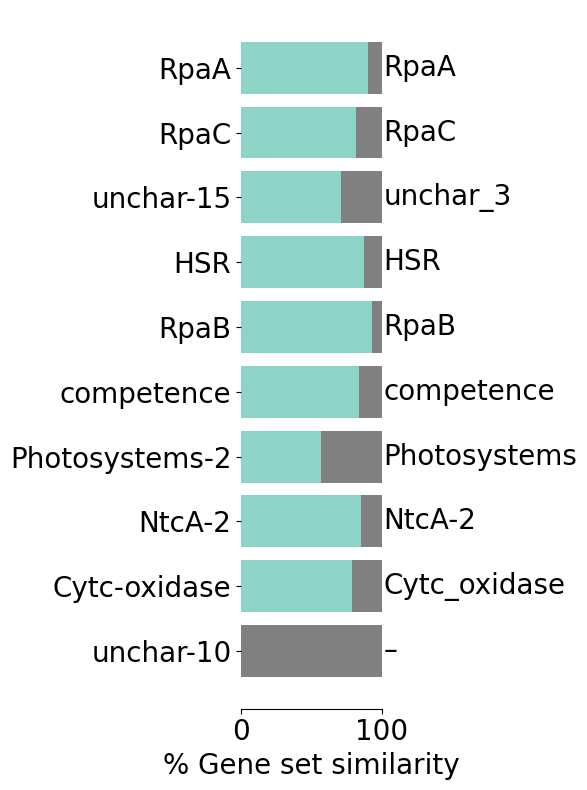

In [28]:

ica_data.imodulon_table['name'] = ica_data.imodulon_table.m.map(names['updated name'].to_dict())
ica_data.imodulon_table['homolog'] = ica_data.imodulon_table.m.map(names['homolog name'].to_dict())
ica_data.imodulon_table['percent identity'] = ica_data.imodulon_table.m.map(names['percent identity'].to_dict())
top10 =ica_data.imodulon_table.sort_values(by='explained_var', ascending=False).head(10)
plot_id = names.loc[top10.index,['updated name','percent identity','homolog name']]
plot_id['updated name']=plot_id['updated name'].replace('RpaA-2','unchar-15')
# Create the plot
fig, ax = plt.subplots(figsize=(6, 8))

# Get the number of items
n_items = len(plot_id)
y_positions = range(n_items, 0, -1)

# Plot background bars (gray)
ax.barh(y_positions, np.repeat(100, n_items), color='gray')

# Plot data bars (teal)
teal_color = '#8DD3C7'
ax.barh(y_positions, plot_id['percent identity'].replace({'–':0}).astype(float), color=teal_color)

# Set the left y-tick labels (gene names)
ax.set_yticks(y_positions)
ax.set_yticklabels(plot_id['updated name'], fontsize=20)

# Set up the x-axis label and limits
ax.set_xlabel('% Gene set similarity', fontsize=20)
ax.set_xlim(0, 100)

# Manually add text annotations for percentages on the right side
for i, (pos, val) in enumerate(zip(y_positions, plot_id['homolog name'])):
    # Position the text at x=101 (just outside the right edge)
    ax.text(101, pos, val, va='center', ha='left', fontsize=20)

# Adjust the plot layout to make room for the right labels
plt.subplots_adjust(right=0.85)  # Reduce this value if labels are cut off

# Keep the tick parameters consistent
ax.tick_params(axis='both', labelsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#plt.savefig('results/imodulons/im_homology.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

Variance explained by ICA modulons: 71.82%
63 Modules with an average module size of 18.0


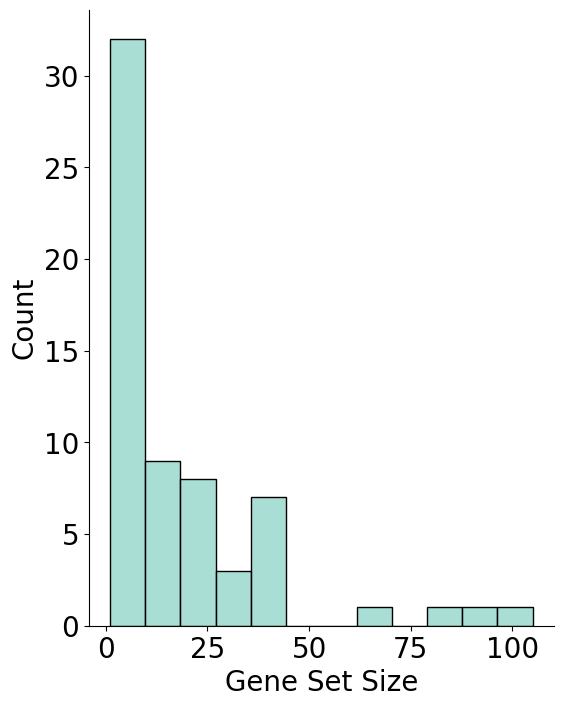

In [29]:

print(f"Variance explained by ICA modulons: {explained_variance(ica_data):.2%}")

modules = []
for i in range(ica_data.M.shape[1]):
    modules.append(len(ica_data.view_imodulon(i)))
    

mod_np = np.array(modules)

print(f"{len(ica_data.imodulon_names)} Modules with an average module size of {np.average(mod_np).round(0)}")
plt.figure(figsize=(6, 8))
ax = sns.histplot(mod_np, color='#8DD3C7')
# Set the x-axis label
ax.set_xlabel('Gene Set Size', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.tick_params(labelsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.savefig('./results/imodulons/ModulesDistribution.png', bbox_inches='tight', dpi=300)
# Display the plot
plt.show()


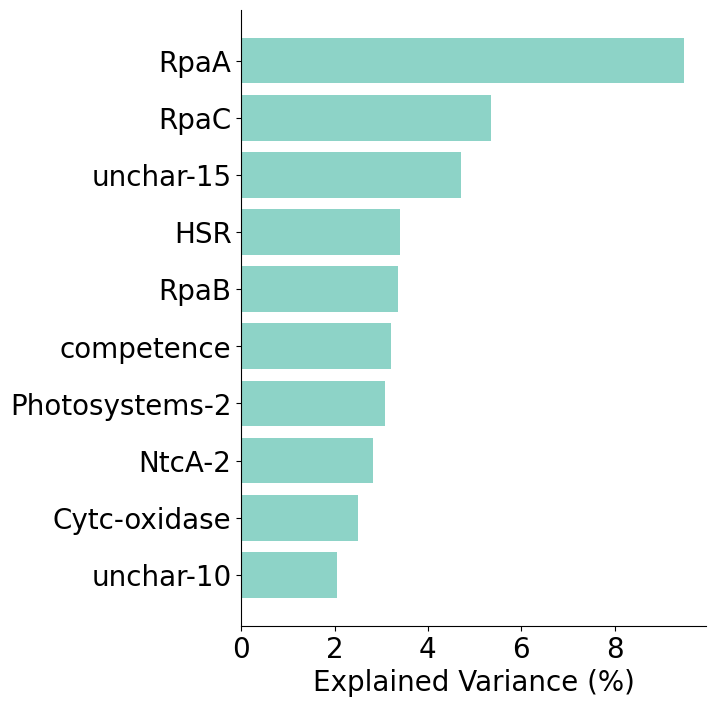

In [30]:
#ica_data1 = load_json_model('data/iM/ica_data.json')
#ica_data1.imodulon_table[ica_data1.imodulon_table['UCSD_iM_homolog']=='competence']
#ica_data.imodulon_table['name']=ica_data1.imodulon_table['updated_name']
#ica_data.imodulon_table['name']=ica_data.imodulon_table['name'].replace('RpaA-2','unchar-15')
# Create figure and axes properly
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(111)  # Add a subplot that takes up the full figure

# Plotting
bar_color = '#8DD3C7'  # Change the bar color here
text_color = 'black'  # Change the font color here

top10 = ica_data.imodulon_table.sort_values(by='explained_var', ascending=False).head(10)
ax.barh(range(10, 0, -1), top10.explained_var*100, tick_label=top10['name'], color=bar_color)
ax.set_xlabel('Explained Variance (%)', fontsize=20)
ax.tick_params(labelsize=20)

# Turn off the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.savefig('results/imodulons/explained-varianc.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
ica_data.imodulon_names = ica_data.imodulon_table['name']
res=ica_data.compute_trn_enrichment(max_regs=1, fdr=1e-3)


,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
2,cmpABCD,CcmR,6.789112e-12,6.789112e-12,1.000000,0.666667,0.800000,4.0,6.0,4.0,1.0
8,ccm-1,CcmR,1.394372e-13,1.394372e-13,0.272727,1.000000,0.428571,6.0,6.0,22.0,1.0
19,IdiB,Fur,2.132615e-04,2.843486e-04,0.250000,0.250000,0.250000,2.0,8.0,8.0,1.0
7,HSR,HrcA,1.729035e-04,5.187106e-04,0.055556,1.000000,0.105263,2.0,2.0,36.0,1.0
10,groELS,HrcA,2.744501e-06,2.744501e-06,0.400000,1.000000,0.571429,2.0,2.0,5.0,1.0
23,NtcA-2,NtcA,3.419841e-12,2.051904e-11,0.225000,0.428571,0.295082,9.0,21.0,40.0,1.0
4,NtcA-1,NtcA,9.312979e-23,2.793894e-22,0.785714,0.523810,0.628571,11.0,21.0,14.0,1.0
5,NtcA-1,NtcB,1.166567e-12,1.749851e-12,0.428571,0.600000,0.500000,6.0,10.0,14.0,1.0
3,oxi-stress,PerR,3.449531e-05,6.899062e-05,0.285714,0.500000,0.363636,2.0,4.0,7.0,1.0
18,IdiB,PerR,4.597099e-05,9.194198e-05,0.250000,0.500000,0.333333,2.0,4.0,8.0,1.0


In [62]:

ica_data.gene_table = ica_data.gene_table.rename(
    columns={'KEGG_Pathway':'kegg_path','KEGG_Module':'kegg_module','COG_category':'cog'})
ica_data.gene_table.kegg_path

def extract_enrichment_description(x, db=None):
    if db == 'regulator':
        return f"{x[db]};({x['TP']:.0f}/{x['imodulon_size']:.0f}/{x['regulon_size']:.0f});(q:{x['qvalue']:.1e})"
    else:
        return f"{x[db]};({x['TP']:.0f}/{x['imodulon_size']:.0f});(q:{x['qvalue']:.1e})"


def extract_multiple_regulator_descriptions(annotation_table, enrichment_df, n_max):
    
    results = {}
    for m, df in enrichment_df.groupby('imodulon'):
        df = df.sort_values(by='qvalue')
        
        enriched_regulators = []
        # Fixed this line - now using index, row instead of row, df
        for idx, row in df.iloc[:n_max].iterrows():
            ann = extract_enrichment_description(row, 'regulator')
            enriched_regulators.append(ann)  
            
        results[m] = " ".join(enriched_regulators)  
            
    annotation_table['regulator'] = annotation_table.index.map(results)
    
    return annotation_table

def compile_module_annotation_table(ica_data, enrichments, n_regs=2):

    enr_ann = ica_data.imodulon_table.copy()

    for db, enr in enrichments.items():
        if db == 'trn':
            extract_multiple_regulator_descriptions(enr_ann, enr, n_max=n_regs)
        else:
            idxs = enr.groupby('imodulon')['qvalue'].idxmin()
            best_enr = enr.loc[idxs].copy().set_index('imodulon')
            best_enr[db] = best_enr.apply(lambda x: extract_enrichment_description(x, db), axis=1)
            enr_ann = enr_ann.merge(best_enr[[db,f'{db}_description']], left_index=True, right_index=True, how='left')

    return enr_ann



db_path = '../Data/annotation'

path_map = pd.read_csv(
    Path(db_path, 'KEGG/descriptions/pathway_descriptions.csv'),
    index_col=0).set_index('pathway')['description'].to_dict()

cog_map = pd.read_csv(
    Path(db_path, 'COG/COG.tsv'), 
    sep='\t', header=None, index_col=0)[1].to_dict()

mod_map = pd.read_csv(
    Path(db_path, 'KEGG/descriptions/KEGG_Modules.csv'), index_col=0
    ).set_index('KeggModuleNR')['KeggModuleName'].str.split(': ').str[1].to_dict()

kegg_paths = ica_data.gene_table.kegg_path.dropna().str.split(',').explode()


func_id_dict = {
    'kegg_path': kegg_paths[kegg_paths.str.startswith('map')],
    'kegg_module': ica_data.gene_table.kegg_module.dropna().str.split(',').explode().dropna(),
    'cog': ica_data.gene_table.cog.dropna().str.split('').str[1:-1].explode().dropna()
}

fun_descr_dict = {
    'kegg_path':path_map,
    'kegg_module':mod_map,
    'cog': cog_map
}

filter_terms = {
    'kegg_module': [
        'Ribosome, archaea',
        ],
    'kegg_path': [
        'Tuberculosis',
         'Longevity regulating pathway - worm', 
         'Type I diabetes mellitus',
         'Legionellosis',
         'Metabolic pathways'
         ], 
    'cog':['Mobilome: prophages, transposons'] # Replaced Nan values
}

enriched = {}

for db, expanded_annotation in func_id_dict.items():

    enr_res = ica_data.compute_annotation_enrichment(
        expanded_annotation.reset_index().rename(columns= {'index':'gene_id'}),db, fdr=1e-2
        )
    
    enr_res[f'{db}_description'] = enr_res[db].map(fun_descr_dict[db])
    enriched[db] = enr_res[~enr_res[f'{db}_description'].isin(filter_terms[db])]
    
# compute trn enrichment separately
enriched['trn'] = ica_data.compute_trn_enrichment(fdr=1e-3)

enr_ann = compile_module_annotation_table(
    ica_data, enrichments=enriched, n_regs=2)

enr_ann[enr_ann[['kegg_path','kegg_module','cog','regulator']].notna().any(axis=1)]

,m,explained_var,n,name,homolog,percent identity,kegg_path,kegg_path_description,kegg_module,kegg_module_description,cog,cog_description,regulator
Cytc-oxidase,1,0.025026,19,Cytc-oxidase,Cytc_oxidase,78.6,map00190;(8/19);(q:8.9e-08),Oxidative phosphorylation,M00155;(3/19);(q:6.3e-05),"Cytochrome c oxidase, prokaryotes",NaN,NaN,NaN
iron,3,0.005094,9,iron,iron,71.6,map02010;(4/9);(q:9.9e-03),ABC transporters,M00190;(4/9);(q:1.2e-08),Iron(III) transport system,NaN,NaN,NaN
competence,6,0.032185,23,competence,competence,84.1,NaN,NaN,NaN,NaN,NaN,NaN,SigF2;(7/23/21);(q:6.4e-10)
Photosystems-1,9,0.009155,37,Photosystems-1,Photosystems,58.2,map00195;(8/37);(q:1.6e-04),Photosynthesis,M00161;(6/37);(q:1.9e-07),Photosystem II,C;(12/37);(q:1.9e-04),Energy production and conversion,RpaB;(14/37/137);(q:6.1e-09)
cmpABCD,10,0.002623,4,cmpABCD,ccm-1/sps,"49.7,45.4",map02010;(4/4);(q:8.7e-05),ABC transporters,M00321;(4/4);(q:4.8e-10),Bicarbonate transport system,P;(4/4);(q:2.8e-04),Inorganic ion transport and metabolism,CcmR;(4/4/6);(q:6.8e-12)
oxi-stress,12,0.003967,7,oxi-stress,oxi_stress_tolerance,74.4,NaN,NaN,NaN,NaN,NaN,NaN,PerR;(2/7/4);(q:6.9e-05)
ribosome-1,13,0.011984,33,ribosome-1,ribosome-1,87.9,map03010;(25/33);(q:6.9e-37),Ribosome,M00178;(25/33);(q:7.0e-37),"Ribosome, bacteria",J;(26/33);(q:3.0e-25),"Translation, ribosomal structure and biogenesis",NaN
NtcA-1,21,0.010478,14,NtcA-1,NtcA-1,81.9,map00910;(10/14);(q:2.4e-17),Nitrogen metabolism,M00438;(7/14);(q:4.2e-13),Nitrate/nitrite transport system,P;(8/14);(q:7.2e-06),Inorganic ion transport and metabolism,NtcA;(11/14/21);(q:2.8e-22) NtcB;(6/14/10);(q:...
HSR,24,0.033928,36,HSR,HSR,87.7,NaN,NaN,NaN,NaN,O;(11/36);(q:6.3e-07),"Posttranslational modification, protein turnov...",rre1;(6/36/7);(q:1.5e-10) HrcA;(2/36/2);(q:5.2...
Photosystems-2,27,0.030770,13,Photosystems-2,Photosystems,56.9,map00196;(10/13);(q:2.1e-19),Photosynthesis - antenna proteins,NaN,NaN,C;(8/13);(q:1.9e-05),Energy production and conversion,NaN


In [65]:
ica_data.imodulon_table = enr_ann
ica_data.imodulon_names = ica_data.imodulon_table['m'].astype(int)
save_to_json(ica_data, '../Data/ica/ica_data.json')